In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from skimage import feature

# 1. Load data 

Useful functions:

In [2]:
def load_image(infilename):
    """Read an image from a file to an array."""
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    """Convert image to 255 scale."""
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    """Concatenate an image and its groundtruth."""
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    """Crop image in patches of width w and height h."""
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_features(img):
    """Extract 6-dimensional features consisting of average RGB color as well as variance."""
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

def extract_features_2d(img):
    """Extract 2-dimensional features consisting of average gray color as well as variance."""
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

def extract_img_features(filename, dim = '2d'):
    """Extract features for a given image."""
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    if dim == '2d':
        X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    else:
        X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])

    return X

def value_to_class(v, foreground_threshold):
    """Classify patch to a label according to threshold."""
    df = np.mean(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def label_to_img(imgwidth, imgheight, w, h, labels):
    """Create image from label vector."""
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    """Overlap image and predicted-label image."""
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

Get training data and labels:

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)] 

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]


In [4]:
N_IMAGES_TRAIN = len(files)

Extract patches:

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

Build training and testing data matrices:

In [6]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
X_train = X[0:len(X)//2]
X_test = X[len(X)//2:len(X)]

Y = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])
Y_train = Y[0:len(X)//2]
Y_test = Y[len(Y)//2:len(Y)]

# 2. Features extraction

Useful functions:

In [7]:
def create_feature_vectors(feat_img, w, h):
    """Create a feature vector of dimension w x h for each patch. Input feat_img is the image resulting of a feature extraction algorithm."""
    feat_patches = img_crop(feat_img, w, h)
    feat_vec = np.array([feat_patches[i].ravel() for i in range(len(feat_patches))])
    return feat_vec

def extract_img_extrafeatures(file, feat = 'hog'):
    """Create a feature vector of dimension w x h for each patch. """
    im = load_image(file)
    
    if feat == 'hog':
        hog_vec = []
        for j in range (3):
            v = feature.hog(im[:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True).reshape((-1, 8))
            hog_vec.append(v)
        feat_vec = np.concatenate(hog_vec, axis=1)
    elif feat == 'lbp':
        feat_vec = create_feature_vectors(feature.local_binary_pattern(im[:,:,0], P = 8, R = 8), 16, 16)
    elif feat == 'canny':
        feat_vec = create_feature_vectors(feature.canny(im[:,:,0]), 16, 16)

    return feat_vec

### 2.1. Canny method: edge detection

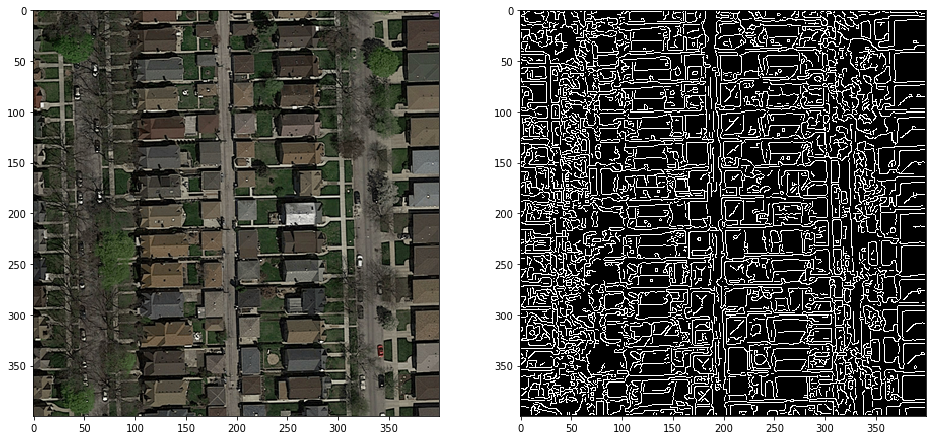

In [8]:
plt.figure(figsize=(16,16))
fc=feature.canny(imgs[0][:,:,0])

plt.subplot(1,2,1)
plt.imshow(imgs[0]);
plt.subplot(1,2,2)
plt.imshow(fc, cmap='Greys_r');


Create matrix of features $62500\times 256$ (256 edge-detection pixels for each patch):

In [9]:
canny_vec = create_feature_vectors(feature.canny(imgs[0][:,:,0]), 16, 16)*1 # convert bool to 0 and 1
for i in range(1, n):
    fc = feature.canny(imgs[i][:,:,0])
    canny_vec = np.vstack((canny_vec, create_feature_vectors(fc, 16, 16)))*1

### 2.2. Local Binary Pattern vector: texture classification


Joint distribution of the gray levels of P  equally spaced pixels on a circle of radius 􏰌R > 0􏰍 that form a circularly symmetric neighbor set.

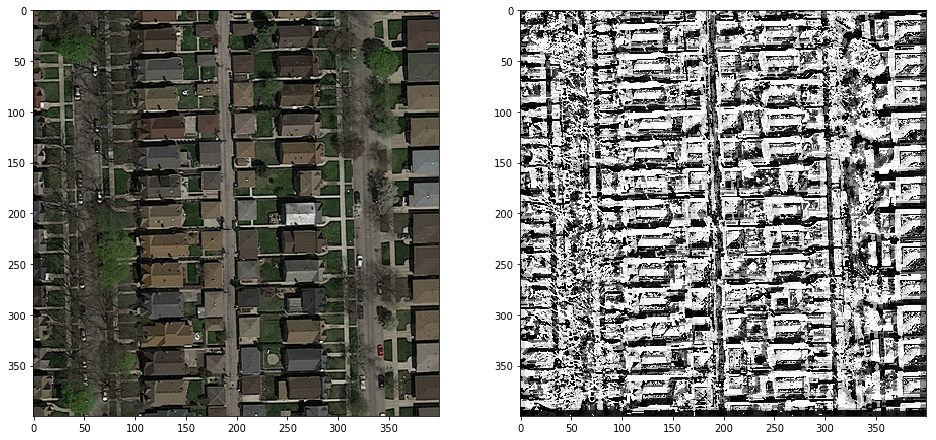

In [10]:
plt.figure(figsize=(16,16))
fc=feature.local_binary_pattern(imgs[0][:,:,0],P = 8,R = 8) 

plt.subplot(1,2,1)
plt.imshow(imgs[0]);
plt.subplot(1,2,2)
plt.imshow(fc, cmap='Greys_r');

Create matrix of features $62500\times 256$ (256 texture pixels for each patch):

In [11]:
lbp_vec = create_feature_vectors(feature.local_binary_pattern(imgs[0][:,:,0], P = 8, R = 8), 16, 16)/255 # scale to (0,1)
for i in range(1, n):
    fc = feature.local_binary_pattern(imgs[i][:,:,0], P = 8, R = 8)
    lbp_vec = np.vstack((lbp_vec, create_feature_vectors(fc, 16, 16)))/255

### 2.3. Histogram of oriented gradients:

It counts occurrences of gradient orientation in localized portions of an image.

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


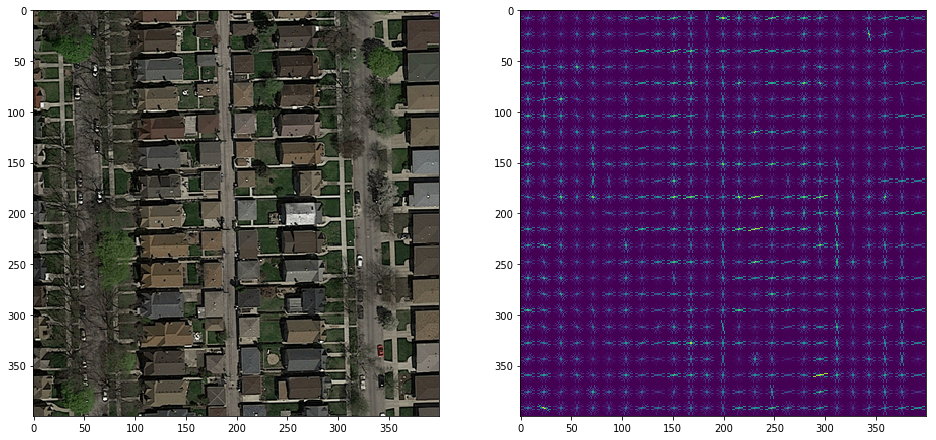

In [12]:
plt.figure(figsize=(16,8))
v, mr=feature.hog(imgs[0][:,:,0], orientations = 8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualise=True, feature_vector=True)
plt.subplot(1,2,1)
plt.imshow(imgs[0]);
plt.subplot(1,2,2)
plt.imshow(mr);

Create matrix of features $62500\times 24$ (8 orientations for each color channel):

In [13]:
hog_vec = []
for j in range (3):
    hog_v = feature.hog(imgs[0][:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True).reshape((-1, 8))
    for i in range(1, n):
        v = feature.hog(imgs[i][:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True)
        hog_v = np.vstack((hog_v, v.reshape((-1, 8))))
    hog_vec.append(hog_v)

hog_vec = np.concatenate(hog_vec, axis=1)

/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Total data matrix for 6 color features (mean and variance for each color channel) + 256 edge features (for each pixel of 16x16 patch for gray scale image) + 256 texture features (for each pixel of 16x16 patch for gray scale image) + 24 color gradient features (histogram of 8 orientations for each color channel): $542$ features.

Include in the data matrix some features:

In [47]:
extrafeat = 'lbp'
extrafeatvec = lbp_vec

In [39]:
Augmented_X = np.concatenate([X, extrafeatvec], axis=1)
X_train = Augmented_X[0:len(X)//2]
X_test = Augmented_X[len(X)//2:len(X)]


# 3. Some classification methods:

$F_1$ score:
$$F_1=2\cdot\frac{TPR \cdot PPV}{TPR + PPV}$$
with $TPR = \frac{TP}{TP+FN}$ and $PPV = \frac{TP}{TP + FP}$.
- TPR: True positive rate 
- PPV: Positive predicted value.

## 3.1. Logistic Regression 

Train classifier:

In [40]:
from sklearn import linear_model

# we create an instance of the classifier and fit the data C = 1/lambda
classif = linear_model.LogisticRegression(C=1e3, class_weight="balanced")
classif.fit(X_train, Y_train)

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Training error:

In [41]:
# Predict on the training set
Z = classif.predict(X_train)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_train)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))

True positive rate = 0.7051107536196015
Positive predicted value = 0.3548387096774194
F1 score = 0.47209909275446377


Test error:

In [42]:
# Predict on the training set
Z = classif.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_test)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))

True positive rate = 0.7159062885326757
Positive predicted value = 0.33516134618715004
F1 score = 0.4565721700153344


Example of image classification from test set:

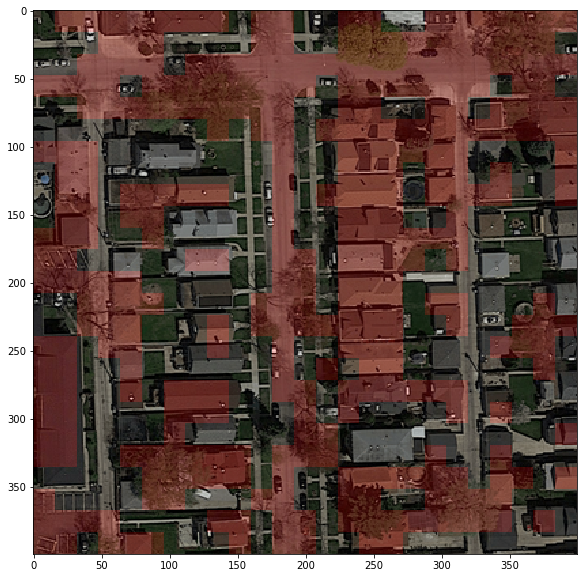

In [44]:
img_idx = 50
X_ = extract_img_features(image_dir + files[img_idx], '3d')
Xx = extract_img_extrafeatures(image_dir + files[img_idx], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)
Zi = classif.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



## 3.2. Random Forest Classifier 

In [48]:
from sklearn import ensemble

classif = ensemble.RandomForestClassifier(100)
classif.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
# Predict on the training set
Z = classif.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_test)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))


True positive rate = 0.3711467324290999
Positive predicted value = 0.60236141685011
F1 score = 0.4592965590905623


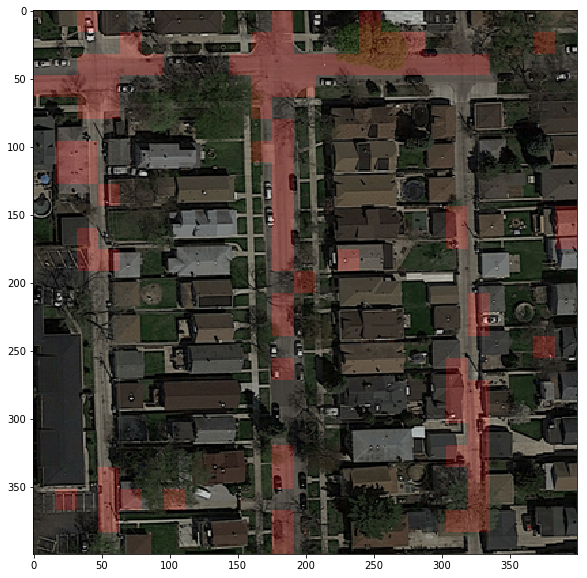

In [49]:
img_idx = 50
X_ = extract_img_features(image_dir + files[img_idx], '3d')
Xx = extract_img_extrafeatures(image_dir + files[img_idx], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)

Zi = classif.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



# 4. Generate submission

Load test images

In [50]:
N_TEST_IMAGES = 50

In [51]:
# Loaded a set of images
root_test_dir = "test_set_images/"
test_dir = ['test_'+str(i)+'/' for i in range(1,N_TEST_IMAGES+1)]
test_images = ['test_'+str(i)+'.png' for i in range(1,N_TEST_IMAGES+1)]


In [55]:
submission_filename = 'prediction.csv'

# with open(submission_filename, 'w') as f:
#     f.write('id,prediction\n')
#     for i in range(N_TEST_IMAGES):
#         X_ = extract_img_features(root_test_dir + test_dir[i]+test_images[i], '3d')
#         Xx = extract_img_extrafeatures (root_test_dir + test_dir[i]+test_images[i], extrafeat)
#         Xi = np.concatenate([X_, Xx], axis = 1)
#         Zi = classif.predict(Xi)
    
#         strings=[]
#         count = 0
#         for j in range(0, 608, patch_size):
#             for k in range(0, 608, patch_size):
#                 strings.append("{:03d}_{}_{},{}".format(i+1, j, k, Zi[count]))
#                 count = count + 1


#         f.writelines('{}\n'.format(s) for s in strings)
        

See one test image vs classification:

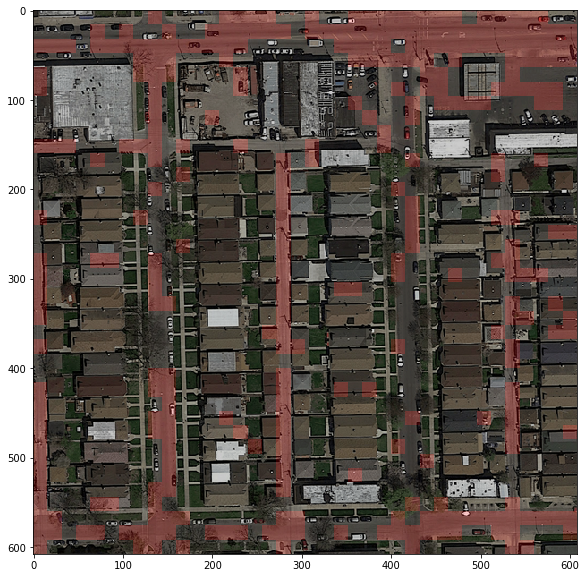

In [56]:
X_ = extract_img_features(root_test_dir + test_dir[0]+test_images[0], '3d')
Xx = extract_img_extrafeatures(root_test_dir + test_dir[0]+test_images[0], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)

Zi = classif.predict(Xi)
predicted_im = label_to_img(608, 608, patch_size, patch_size, Zi)
im = load_image(root_test_dir + test_dir[0]+test_images[0])
new_img = make_img_overlay(im, predicted_im)

predicted_im.shape
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(new_img)